## Seasonal Exponential Smoothing Model

In this notebook, we implement a seasonal Holt Winters model to predict PA volume. This is a type of exponential smoothing model. More information can be found at the following links: <br>
https://www.statsmodels.org/dev/examples/notebooks/generated/exponential_smoothing.html
https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html

We begin by loading packages and assembling the data.

In [171]:
# Import packages

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import itertools

In [172]:
# Suppress convergence warnings

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [186]:
# Load data

dates_df = pd.read_csv('dim_date.csv')
claims_df = pd.read_csv('dim_claims.csv')
pa_df = pd.read_csv('dim_pa.csv')
bridge_df = pd.read_csv('bridge.csv')

In [187]:
# Create an extended date table with PA counts
date_ext_df = dates_df.copy()

# Add column of PA counts
bridge_pa_df = bridge_df.copy()
bridge_pa_df = bridge_pa_df.dropna()
date_ext_df['pa_volume'] = date_ext_df['dim_date_id'].map(bridge_pa_df['dim_date_id'].value_counts())

# Drop dates with no associated PA volume
date_ext_df = date_ext_df.dropna(subset = ['pa_volume'])

# Show the header
date_ext_df.head()

,dim_date_id,date_val,calendar_year,calendar_month,calendar_day,day_of_week,is_weekday,is_workday,is_holiday,pa_volume
0,1,2017-01-01,2017,1,1,1,0,0,1,94.0
1,2,2017-01-02,2017,1,2,2,1,0,0,437.0
2,3,2017-01-03,2017,1,3,3,1,1,0,614.0
3,4,2017-01-04,2017,1,4,4,1,1,0,591.0
4,5,2017-01-05,2017,1,5,5,1,1,0,598.0


We will train the model on data from January 2017 through March 2019 and test the model on data from April 2019 through December 2019. Therefore, we need to create a training subset. We will then plot it.

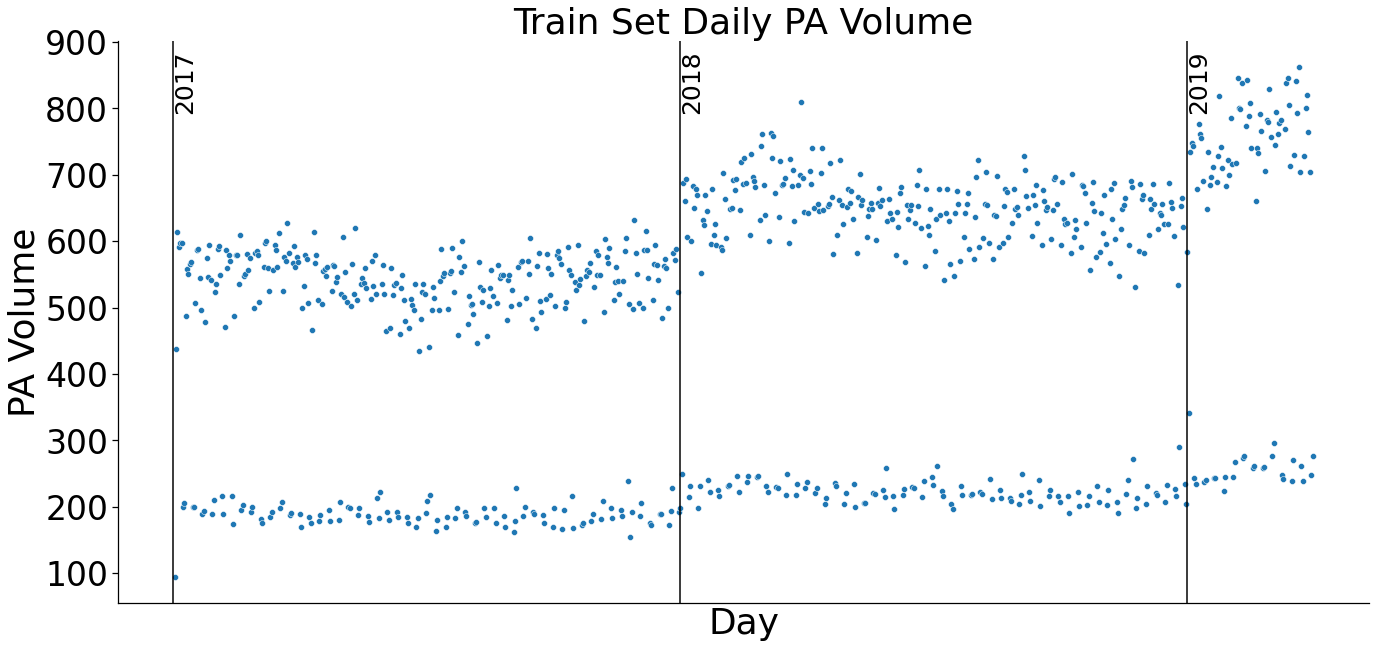

In [221]:
# Create training subset
train_df = date_ext_df[(date_ext_df['calendar_year'] <= 2018) | (date_ext_df['calendar_month'] <= 3)]

# Plot training set
with sns.plotting_context("notebook", font_scale=3):
    pa_train_plot = sns.relplot(data=train_df,
                            x='dim_date_id',
                            y='pa_volume',
                            height=10,
                            aspect=20/10)
    pa_train_plot.set(title='Train Set Daily PA Volume')
    pa_train_plot.set_axis_labels('Day', 'PA Volume')
plt.xticks([])
plt.axvline(-0.5, color='black')
plt.text(0,800,'2017',rotation=90,fontsize=25)
plt.axvline(364.5, color='black')
plt.text(365,800,'2018',rotation=90,fontsize=25)
plt.axvline(729.5, color='black')
plt.text(730,800,'2019',rotation=90,fontsize=25)
plt.show()

We see that the data separates into two distinct curves. This separation can be mostly explained by whether each date is a workday or not.

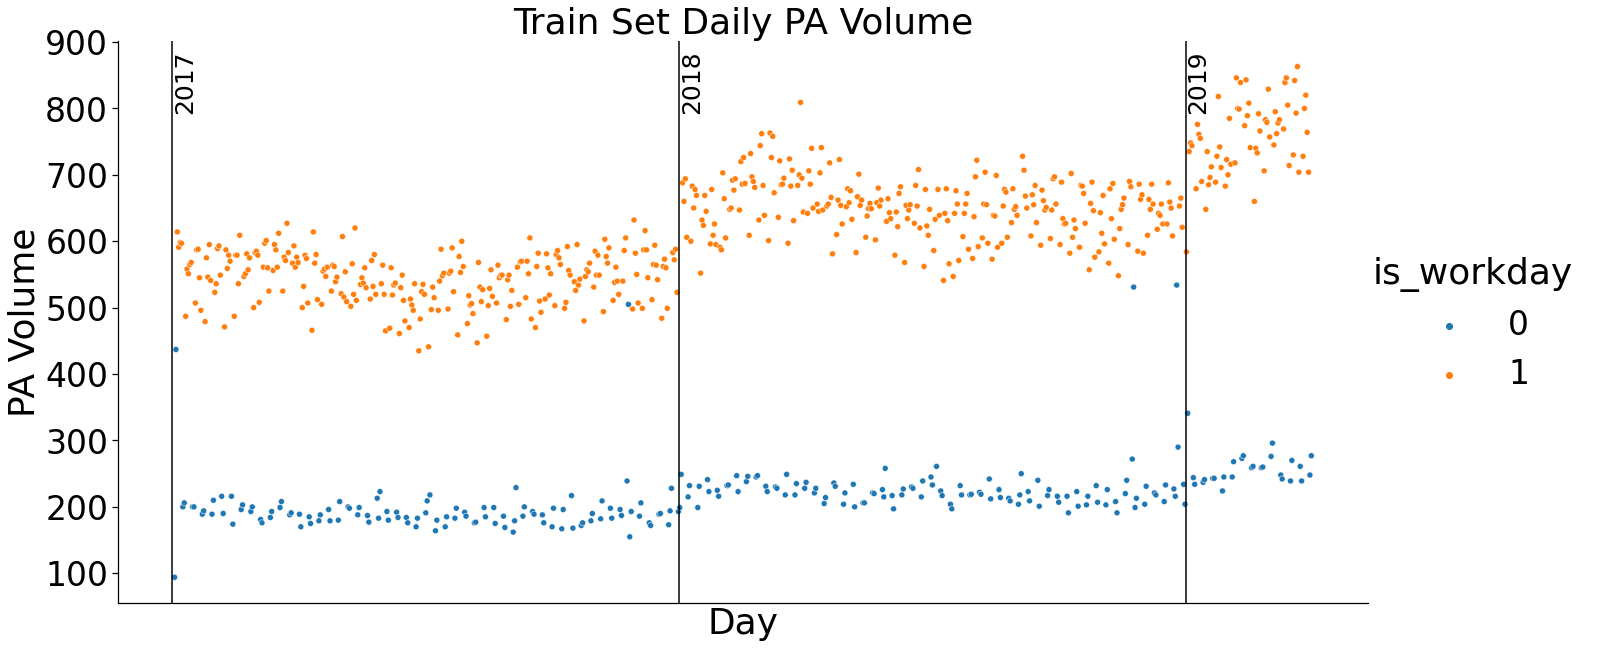

In [222]:
# Plot training set with 
with sns.plotting_context("notebook", font_scale=3):
    pa_train_plot = sns.relplot(data=train_df,
                            x='dim_date_id',
                            y='pa_volume',
                            hue='is_workday',
                            height=10,
                            aspect=20/10)
    pa_train_plot.set(title='Train Set Daily PA Volume')
    pa_train_plot.set_axis_labels('Day', 'PA Volume')
plt.xticks([])
plt.axvline(-0.5, color='black')
plt.text(0,800,'2017',rotation=90,fontsize=25)
plt.axvline(364.5, color='black')
plt.text(365,800,'2018',rotation=90,fontsize=25)
plt.axvline(729.5, color='black')
plt.text(730,800,'2019',rotation=90,fontsize=25)
plt.show()

We see that daily PA volume depends greatly on whether or not each day is a workday. However, there are a small number of non-workdays which behave like workdays. We therefore create a new field which marks these outlier non-workdays as workdays.

C:\Users\Luke\AppData\Local\Temp/ipykernel_23828/1937346425.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['is_workday_new'] = train_df['is_workday'] \


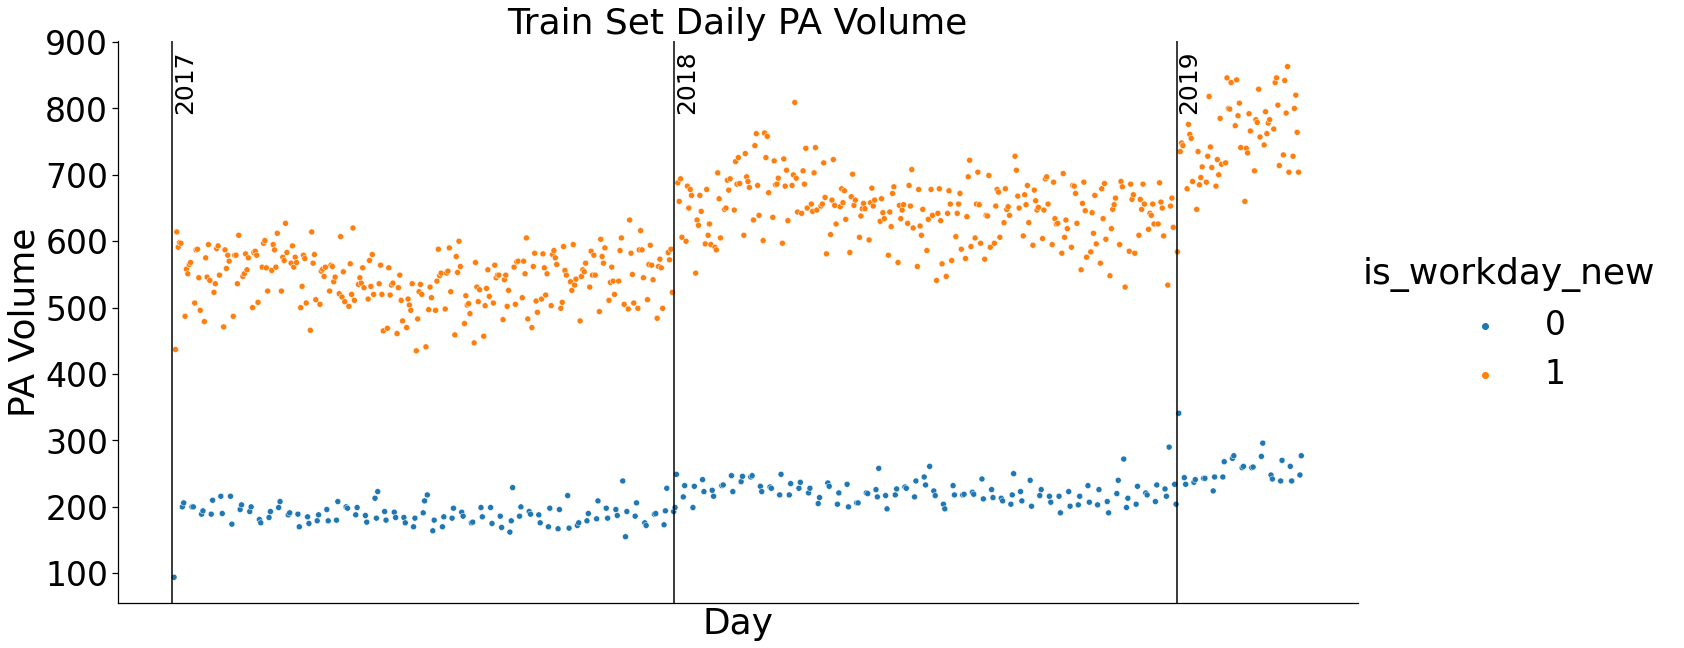

In [223]:
# Create a field for adjusted workday which corrects the outliers in is_workday

# Create a subdataframe of non-workdays in the train set with the purpose of computing statistics
nonworkday_stats_df = train_df[train_df['is_workday'] == 0]

# Get PA statistics for non-workdays
pa_mean = nonworkday_stats_df['pa_volume'].mean()
pa_std = nonworkday_stats_df['pa_volume'].std()

# Create adjusted workday field
# Non-workdays count as workdays if their PA volumes are at least three standard deviations above the mean
train_df['is_workday_new'] = train_df['is_workday'] \
    + (1-train_df['is_workday'])*(train_df['pa_volume'] > pa_mean+3*pa_std)

# Plot training set with adjusted is_workday
with sns.plotting_context("notebook", font_scale=3):
    pa_new_train_plot = sns.relplot(data=train_df,
                            x='dim_date_id',
                            y='pa_volume',
                            hue='is_workday_new',
                            height=10,
                            aspect=20/10)  
    pa_new_train_plot.set(title='Train Set Daily PA Volume')
    pa_new_train_plot.set_axis_labels('Day', 'PA Volume')
plt.xticks([])
plt.axvline(-0.5, color='black')
plt.text(0,800,'2017',rotation=90,fontsize=25)
plt.axvline(364.5, color='black')
plt.text(365,800,'2018',rotation=90,fontsize=25)
plt.axvline(729.5, color='black')
plt.text(730,800,'2019',rotation=90,fontsize=25)
plt.show()

From here on out, whenever we refer to workdays in the training set, we are referring to dates which have a 1 in the 'is_workday_new' field.

Since workdays and non-workdays behave differently, we will build two models: one for workdays, and one for non-workdays. However, when building an exponential smoothing model on daily data, we need data for each day. Therefore, we will fill in gaps between workdays and non-workdays using linear interpolation.

C:\Users\Luke\AppData\Local\Temp/ipykernel_23828/2113003984.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['pa_volume_workday'] = train_df['pa_volume'] * train_df['is_workday_new']
C:\Users\Luke\AppData\Local\Temp/ipykernel_23828/2113003984.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['pa_volume_nonworkday'] = train_df['pa_volume'] * (1 - train_df['is_workday_new'])
C:\Users\Luke\.conda\envs\erdos\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value 

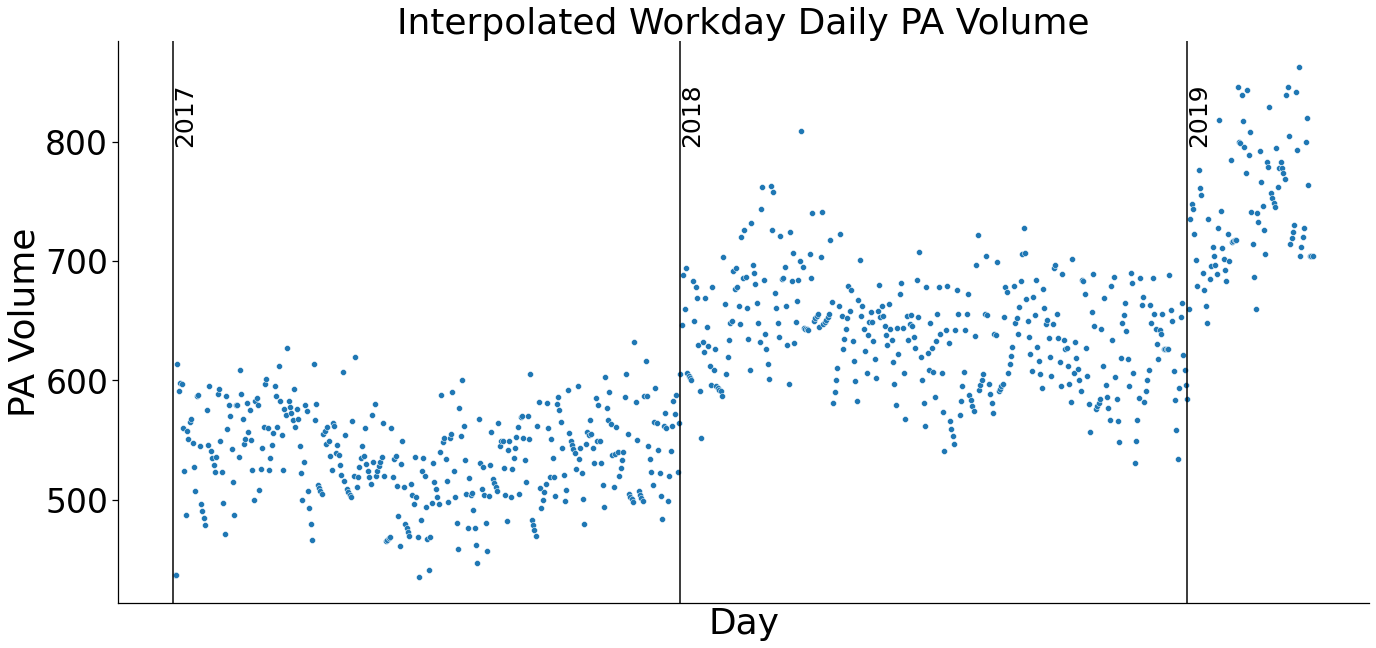

In [224]:
# Split PA volume into separate fields for workdays and non-workdays, and interpolate missing values

# Create workday and nonworkday PA fields
train_df['pa_volume_workday'] = train_df['pa_volume'] * train_df['is_workday_new']
train_df['pa_volume_nonworkday'] = train_df['pa_volume'] * (1 - train_df['is_workday_new'])

# Fill in zeros for workday PA volumes with interpolated values
i = 0
previous_workday_index = -1
while i < len(train_df):
    # Test if the current row corresponds to a workday
    if train_df.iloc[i]['is_workday_new']:
        # Mark the current index as the previous workday index and continue iterating
        previous_workday_index = i
        i += 1
    else:
        # Find the index for the next workday
        next_workday_index = i
        next_workday_found = 0
        while not(next_workday_found):
            # If we are at the end of the dataframe, stop iterating and use a special index
            if next_workday_index == len(train_df) - 1:
                next_workday_index = -1
                next_workday_found = 1
            else:
                next_workday_index += 1
                if train_df.iloc[next_workday_index]['is_workday_new']:
                    next_workday_found = 1
        # Test if the first workday has yet to be identified
        if previous_workday_index == -1:
            # In this case, take the PA volume from the next workday
            train_df.at[i, 'pa_volume_workday'] = train_df.iloc[next_workday_index]['pa_volume_workday']
            # Prepare for next loop
            i += 1
        # Test if the final workday has been identified
        elif next_workday_index == -1:
            # In this case, take the PA volume from the previous workday
            train_df.at[i, 'pa_volume_workday'] = train_df.iloc[previous_workday_index]['pa_volume_workday']
            # Prepare for next loop
            i += 1
        else:
            # Interpolate between the previous and next workdays
            x = np.arange(previous_workday_index, next_workday_index+1)
            xp = [previous_workday_index, next_workday_index]
            fp = [train_df.iloc[previous_workday_index]['pa_volume_workday'], 
                  train_df.iloc[next_workday_index]['pa_volume_workday']]
            train_df.at[x, 'pa_volume_workday'] = np.interp(x, xp, fp)
            # Prepare for next loop
            previous_workday_index = next_workday_index
            i = next_workday_index + 1
            
# Plot pa_volume_workday on the training set
with sns.plotting_context("notebook", font_scale=3):
    pa_volume_workday_train_plot = sns.relplot(data=train_df,
                            x='dim_date_id',
                            y='pa_volume_workday',
                            height=10,
                            aspect=20/10)  
    pa_volume_workday_train_plot.set(title='Interpolated Workday Daily PA Volume')
    pa_volume_workday_train_plot.set_axis_labels('Day', 'PA Volume')
plt.xticks([])
plt.axvline(-0.5, color='black')
plt.text(0,800,'2017',rotation=90,fontsize=25)
plt.axvline(364.5, color='black')
plt.text(365,800,'2018',rotation=90,fontsize=25)
plt.axvline(729.5, color='black')
plt.text(730,800,'2019',rotation=90,fontsize=25)
plt.show()

C:\Users\Luke\.conda\envs\erdos\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


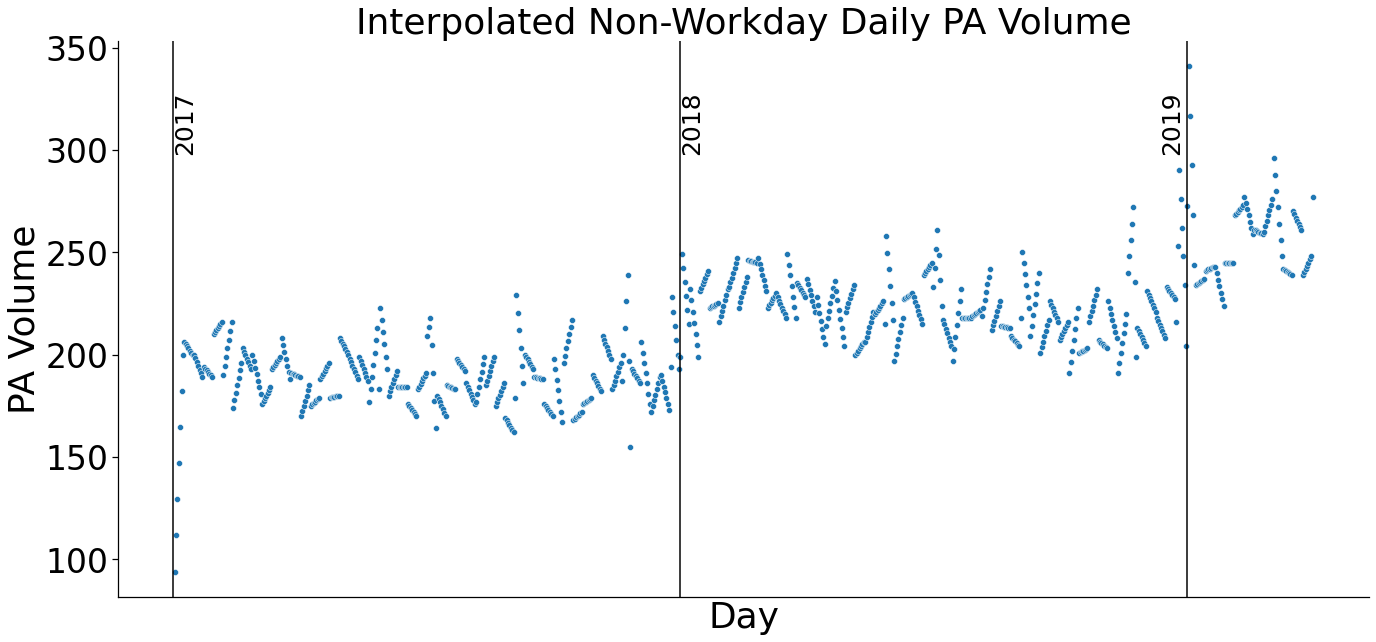

In [225]:
# Fill in zeros for non-workday PA volumes with interpolated values
i = 0
previous_nonworkday_index = -1
while i < len(train_df):
    # Test if the current row corresponds to a non-workday
    if not(train_df.iloc[i]['is_workday_new']):
        # Mark the current index as the previous non-workday index and continue iterating
        previous_nonworkday_index = i
        i += 1
    else:
        # Find the index for the next non-workday
        next_nonworkday_index = i
        next_nonworkday_found = 0
        while not(next_nonworkday_found):
            # If we are at the end of the dataframe, stop iterating and use a special index
            if next_nonworkday_index == len(train_df) - 1:
                next_nonworkday_index = -1
                next_nonworkday_found = 1
            else:
                next_nonworkday_index += 1
                if not(train_df.iloc[next_nonworkday_index]['is_workday_new']):
                    next_nonworkday_found = 1
        # Test if the first non-workday has yet to be identified
        if previous_nonworkday_index == -1:
            # In this case, take the PA volume from the next non-workday
            train_df.at[i, 'pa_volume_nonworkday'] = train_df.iloc[next_nonworkday_index]['pa_volume_nonworkday']
            # Prepare for next loop
            i += 1
        # Test if the final non-workday has been identified
        elif next_nonworkday_index == -1:
            # In this case, take the PA volume from the previous nonworkday
            train_df.at[i, 'pa_volume_nonworkday'] = train_df.iloc[previous_nonworkday_index]['pa_volume_nonworkday']
            # Prepare for next loop
            i += 1
        else:
            # Interpolate between the previous and next nonworkdays
            x = np.arange(previous_nonworkday_index, next_nonworkday_index+1)
            xp = [previous_nonworkday_index, next_nonworkday_index]
            fp = [train_df.iloc[previous_nonworkday_index]['pa_volume_nonworkday'], 
                  train_df.iloc[next_nonworkday_index]['pa_volume_nonworkday']]
            train_df.at[x, 'pa_volume_nonworkday'] = np.interp(x, xp, fp)
            # Prepare for next loop
            previous_nonworkday_index = next_nonworkday_index
            i = next_nonworkday_index + 1
            
# Plot pa_volume_workday on the training set
with sns.plotting_context("notebook", font_scale=3):
    pa_volume_nonworkday_train_plot = sns.relplot(data=train_df,
                            x='dim_date_id',
                            y='pa_volume_nonworkday',
                            height=10,
                            aspect=20/10)  
    pa_volume_nonworkday_train_plot.set(title='Interpolated Non-Workday Daily PA Volume')
    pa_volume_nonworkday_train_plot.set_axis_labels('Day', 'PA Volume')
plt.xticks([])
plt.axvline(-0.5, color='black')
plt.text(0,300,'2017',rotation=90,fontsize=25)
plt.axvline(364.5, color='black')
plt.text(365,300,'2018',rotation=90,fontsize=25)
plt.axvline(729.5, color='black')
plt.text(710,300,'2019',rotation=90,fontsize=25)
plt.show()

We are now ready to build models and measure their accuracy. Exponential smoothing models require three smoothing parameters, so we will test various combinations of smoothing parameter values to see which combination results in the best accuracy.
</br>
</br>
To assess accuracy, we first predict the PA volume for each day in the test set using the workday model for workdays and the non-workday model for non-workdays. Then, for each month in the test set, we compute the difference between the actual total PA volume for that month and the sum of the predicted PA volumes for all day in that month. We obtain an error estimate by dividing the absolute value of this difference by the total PA volume for that month so that the difference is relative to the total PA volume. For example, if total monthly PA volume is 100 and the error is at most 1%, then the predicted PA volume for that month is between 99 and 101. Finally, we average these errors over all months in the test set.

In [79]:
# Let's write a function that will help us measure accuracy given various smoothing parameters

def model_fit_and_accuracy(alpha, beta, gamma):
    # Fit models and forecast data
    
    # Fit a seasonal Holt Winters model to the workday data
    y_workday = train_df['pa_volume_workday']
    workday_fit = ExponentialSmoothing(y_workday,
                                       trend="add",
                                       seasonal="add",
                                       seasonal_periods=365,
                                       initialization_method="estimated"
                                      ).fit(smoothing_level=alpha,
                                            smoothing_trend=beta,
                                            smoothing_seasonal=gamma)
    
    # Forecast future workday pa volume
    y_all = workday_fit.fittedvalues
    remaining_dates = len(date_ext_df) - len(train_df)
    y_all_workday = y_all.append(workday_fit.forecast(remaining_dates))
    
    # Fit a seasonal Holt Winters model to the nonworkday data
    y_nonworkday = train_df['pa_volume_nonworkday']
    nonworkday_fit = ExponentialSmoothing(y_nonworkday,
                                       trend="add",
                                       seasonal="add",
                                       seasonal_periods=365,
                                       initialization_method="estimated"
                                      ).fit(smoothing_level=alpha,
                                            smoothing_trend=beta,
                                            smoothing_seasonal=gamma)
    
    # Forecast future nonworkday pa volume
    y_all = nonworkday_fit.fittedvalues
    y_all_nonworkday = y_all.append(nonworkday_fit.forecast(remaining_dates))
    
    ####################################
    
    # Add forecasted data to full dataframe
    date_ext_df2 = date_ext_df.copy()
    date_ext_df2['workday_pred'] = y_all_workday
    date_ext_df2['nonworkday_pred'] = y_all_nonworkday
    is_workday_new = train_df['is_workday_new']
    is_workday_new = is_workday_new.append(date_ext_df['is_workday'][len(is_workday_new):])
    date_ext_df2['is_workday_new'] = is_workday_new
    
    ####################################

    # Create column of predicted values in the larger dataframe
    
    # Include predictions for workdays which apply only to workdays
    date_ext_df2['pa_pred'] = date_ext_df2['is_workday_new'] * date_ext_df2['workday_pred']
    
    # Add predictions for non-workdays
    date_ext_df2['pa_pred'] = date_ext_df2['pa_pred'] \
        + (1 - date_ext_df2['is_workday_new']) * date_ext_df2['nonworkday_pred']
    
    ####################################
    
    # Create a new dataframe which sums pa_count and pa_pred by month
    
    # Add column for month number to dataframe
    date_months_df = date_ext_df2.copy()
    date_months_df['month_number'] = date_months_df['calendar_month'] + 12*(date_months_df['calendar_year'] - 2017)
    
    # Create dataframe with aggregated data for each month
    date_monthly_df = date_months_df[['month_number', 'pa_volume', 'pa_pred']]
    date_monthly_df = date_monthly_df.groupby(by = 'month_number', as_index = False).sum()
    
    ####################################
    
    # Measure error

    # Create a column which measures error for each month
    # We will divide the difference between pred and actual from total actual
    date_monthly_df['error'] = (np.absolute(date_monthly_df['pa_volume'] - date_monthly_df['pa_pred']) \
        / date_monthly_df['pa_volume'])

    # Recreate monthly train and test dataframes
    # The train dataframe contains the first 2.25 years, or 24+3=27 months
    train_monthly_df = date_monthly_df.loc[:26]
    test_montly_df = date_monthly_df.loc[27:]

    # Compute train and text errors by averaging months
    train_error = np.mean(train_monthly_df['error'])*100
    test_error = np.mean(test_montly_df['error'])*100

    # Generate output
    return [train_error, test_error]

In [13]:
# Loop through smoothing parameters and measure accuracies

# Create list of parameter values to use
param_values = [0.99, 0.95, 0.9, 0.5, 0.1, 0.05, 0.01]

# Create lists of parameter indices
indices = np.arange(len(param_values))

# Create dataframe for storing accuracies
error_df = pd.DataFrame(columns=['alpha', 'beta', 'gamma', 'train_error', 'test_error'])

n = 0
for i in itertools.product(indices, indices, indices):
    errors = model_fit_and_accuracy(param_values[i[0]], param_values[i[1]], param_values[i[2]])
    print(param_values[i[0]], param_values[i[1]], param_values[i[2]])
    print(errors)
    error_df.loc[n] = np.append([param_values[i[0]], param_values[i[1]], param_values[i[2]]], errors)
    n += 1

0.99 0.99 0.99
[0.6909238137365871, 41.798782355082515]
0.99 0.99 0.95
[0.7106537906855583, 40.555385592315204]
0.99 0.99 0.9
[0.7366205619129707, 47.17913841989525]
0.99 0.99 0.5
[0.9085071499528311, 147.54049011242142]
0.99 0.99 0.1
[0.6505362722538455, 205.38863414244523]
0.99 0.99 0.05
[0.6201782038681718, 202.94817190958025]
0.99 0.99 0.01
[0.6018893964284018, 217.74133997153396]
0.99 0.95 0.99
[0.7027183134768035, 42.93203645869516]
0.99 0.95 0.95
[0.723037581364361, 45.83266949542106]
0.99 0.95 0.9
[0.7501308163337533, 40.92884005251107]
0.99 0.95 0.5
[0.9106120964193868, 134.11100981307254]
0.99 0.95 0.1
[0.6504301497118445, 196.5699505337641]
0.99 0.95 0.05
[0.6239926073763148, 199.95345313741188]
0.99 0.95 0.01
[0.6063326501173448, 218.7148292509835]
0.99 0.9 0.99
[0.7187760765105717, 45.02099546461008]
0.99 0.9 0.95
[0.73904209225899, 44.231325084171615]
0.99 0.9 0.9
[0.7654299548162543, 52.86436858289917]
0.99 0.9 0.5
[0.9115019008288086, 107.133711571455]
0.99 0.9 0.1
[0.6

0.5 0.99 0.1
[0.9794158999882362, 113.88421543356016]
0.5 0.99 0.05
[0.9658907529153729, 95.99097013567585]
0.5 0.99 0.01
[0.9493897414989843, 78.76389486650281]
0.5 0.95 0.99
[0.8802710650294665, 162.3938582752344]
0.5 0.95 0.95
[0.8941325031274168, 166.14511771776108]
0.5 0.95 0.9
[0.9090482726798835, 172.3449093750878]
0.5 0.95 0.5
[0.9714262242021057, 193.38158670292768]
0.5 0.95 0.1
[0.9491220039742164, 83.07370917232014]
0.5 0.95 0.05
[0.9277581643405194, 64.44450649508393]
0.5 0.95 0.01
[0.9071794891540005, 50.35779182320543]
0.5 0.9 0.99
[0.8767523146433611, 166.7401394321323]
0.5 0.9 0.95
[0.8897271240121105, 169.68265109863697]
0.5 0.9 0.9
[0.9035596201966827, 174.32854619206512]
0.5 0.9 0.5
[0.9647588088177854, 172.0063323369744]
0.5 0.9 0.1
[0.9050489262132024, 56.174047917239655]
0.5 0.9 0.05
[0.8839452318927861, 33.58924528815866]
0.5 0.9 0.01
[0.8614927477382559, 21.806597778709353]
0.5 0.5 0.99
[0.8250766530259829, 141.4457070136867]
0.5 0.5 0.95
[0.8341241152180761, 13

0.01 0.95 0.5
[1.9128609503620058, 17.508994528975]
0.01 0.95 0.1
[1.2149966004042179, 31.03573221986246]
0.01 0.95 0.05
[1.219473133525778, 40.77813027830773]
0.01 0.95 0.01
[1.3319076099665583, 44.619997672958874]
0.01 0.9 0.99
[1.35294274048954, 35.18980710855125]
0.01 0.9 0.95
[1.3836356548025392, 34.7932659325713]
0.01 0.9 0.9
[1.4270998915034214, 34.07852824016327]
0.01 0.9 0.5
[1.9016914304525745, 15.475715320247394]
0.01 0.9 0.1
[1.4184206337189011, 46.251967300626816]
0.01 0.9 0.05
[1.55764051447706, 48.858591092679426]
0.01 0.9 0.01
[1.6881411476139128, 47.61767513739608]
0.01 0.5 0.99
[1.4813868709248104, 9.093009426414229]
0.01 0.5 0.95
[1.5052024210592516, 10.131116947123504]
0.01 0.5 0.9
[1.5392256244556208, 11.89881022050841]
0.01 0.5 0.5
[1.949650715285807, 43.407929862815195]
0.01 0.5 0.1
[2.4426335988736962, 64.4312855763888]
0.01 0.5 0.05
[2.40585324513808, 57.158109513505586]
0.01 0.5 0.01
[2.3334707393721654, 49.95025287836758]
0.01 0.1 0.99
[1.263546944549359, 2.9

In [31]:
# Return the row corresponding to the best performing model

error_df.loc[error_df['test_error'] == error_df['test_error'].min()]

,alpha,beta,gamma,train_error,test_error
244,0.1,0.01,0.01,0.737521,1.830959


In [52]:
# Search the parameter space more thoroughly near the optimal model

# Create list of parameter values to use
param_values = [0.125, 0.1, 0.075, 0.05, 0.025, 0.01]

# Create lists of parameter indices
indices = np.arange(len(param_values))

# Create dataframe for storing accuracies
error_df2 = pd.DataFrame(columns=['alpha', 'beta', 'gamma', 'train_error', 'test_error'])

n = 0
for i in itertools.product(indices, indices, indices):
    errors = model_fit_and_accuracy(param_values[i[0]], param_values[i[1]], param_values[i[2]])
    print(param_values[i[0]], param_values[i[1]], param_values[i[2]])
    print(errors)
    error_df2.loc[n] = np.append([param_values[i[0]], param_values[i[1]], param_values[i[2]]], errors)
    n += 1

0.125 0.125 0.125
[0.5979940822632959, 52.037947787034334]
0.125 0.125 0.1
[0.5906089949401457, 51.21766086131141]
0.125 0.125 0.075
[0.5835317935832192, 51.057075898888584]
0.125 0.125 0.05
[0.5747639774588306, 48.74587912043775]
0.125 0.125 0.025
[0.5674841736445578, 48.01452283703026]
0.125 0.125 0.01
[0.5618647469505174, 47.27685907143477]
0.125 0.1 0.125
[0.6043613791906356, 42.074972087738495]
0.125 0.1 0.1
[0.5974829028496315, 41.581117519157814]
0.125 0.1 0.075
[0.5902818925383887, 40.621049550631064]
0.125 0.1 0.05
[0.5832182256875423, 40.52748014292268]
0.125 0.1 0.025
[0.5756996545464955, 39.29739825523384]
0.125 0.1 0.01
[0.5713207448184063, 39.01987441306654]
0.125 0.075 0.125
[0.6316332379398455, 32.939013166598386]
0.125 0.075 0.1
[0.6250757512497602, 32.33723185781188]
0.125 0.075 0.075
[0.6185229591544988, 31.733376143181523]
0.125 0.075 0.05
[0.6121072320197417, 31.161604547466524]
0.125 0.075 0.025
[0.6056378984777552, 30.701782326059867]
0.125 0.075 0.01
[0.60217926

0.025 0.125 0.075
[1.3233089040702104, 16.12987245415544]
0.025 0.125 0.05
[1.3155633388870678, 16.19067659444942]
0.025 0.125 0.025
[1.3047977031816829, 16.217337664099173]
0.025 0.125 0.01
[1.2977372554241313, 16.45044678458859]
0.025 0.1 0.125
[1.297365195851673, 12.779164763492457]
0.025 0.1 0.1
[1.2870372017172576, 12.852945378807018]
0.025 0.1 0.075
[1.2755868922881717, 12.952211158658178]
0.025 0.1 0.05
[1.2623015372862236, 12.905785687843371]
0.025 0.1 0.025
[1.2487978920573375, 12.956770021041564]
0.025 0.1 0.01
[1.2394609188974595, 13.004779364079166]
0.025 0.075 0.125
[1.2698839408464755, 7.544608242988509]
0.025 0.075 0.1
[1.258663988737507, 7.497724213322908]
0.025 0.075 0.075
[1.2469870819956268, 7.428893191379903]
0.025 0.075 0.05
[1.237404813530377, 7.340957808825863]
0.025 0.075 0.025
[1.2268015231027818, 7.249210032721185]
0.025 0.075 0.01
[1.219803510718859, 7.213833461600827]
0.025 0.05 0.125
[1.2624803513602219, 2.8404877815197485]
0.025 0.05 0.1
[1.252349747059131

In [53]:
# Return the row corresponding to the best performing model

error_df2.loc[error_df2['test_error'] == error_df2['test_error'].min()]

,alpha,beta,gamma,train_error,test_error
102,0.075,0.01,0.125,0.858389,1.67055


In [54]:
# Compute the best performing model's accuracy

err_index = error_df2['test_error'].idxmin()
print('Train Accuracy:', 100-error_df2.iloc[err_index][3])
print('Test Accuracy:', 100-error_df2.iloc[err_index][4])

Train Accuracy: 99.1416111541733
Test Accuracy: 98.32944958423585


The most accurate exponential smoothing model uses alpha=0.075, beta=0.01, and gamma=0.125, in which we obtain a training set accuracy of 99.14% and a testing set accuracy of 98.33%.

Let's better understand the best model.

In [193]:
# Build the best performing model manually
    
# Manually set parameters
alpha = 0.075
beta = 0.01
gamma = 0.125

# Fit models and forecast data
# Fit a seasonal Holt Winters model to the workday data
y_workday = train_df['pa_volume_workday']
workday_fit = ExponentialSmoothing(y_workday,
                                   trend="add",
                                   seasonal="add",
                                   seasonal_periods=365,
                                   initialization_method="estimated"
                                  ).fit(smoothing_level=alpha,
                                        smoothing_trend=beta,
                                        smoothing_seasonal=gamma)

# Forecast future workday pa volume
y_all = workday_fit.fittedvalues
remaining_dates = len(date_ext_df) - len(train_df)
y_all_workday = y_all.append(workday_fit.forecast(remaining_dates))

# Fit a seasonal Holt Winters model to the nonworkday data
y_nonworkday = train_df['pa_volume_nonworkday']
nonworkday_fit = ExponentialSmoothing(y_nonworkday,
                                   trend="add",
                                   seasonal="add",
                                   seasonal_periods=365,
                                   initialization_method="estimated"
                                  ).fit(smoothing_level=alpha,
                                        smoothing_trend=beta,
                                        smoothing_seasonal=gamma)

# Forecast future nonworkday pa volume
y_all = nonworkday_fit.fittedvalues
y_all_nonworkday = y_all.append(nonworkday_fit.forecast(remaining_dates))

####################################

# Add forecasted data to full dataframe
date_ext_df2 = date_ext_df.copy()
date_ext_df2['workday_pred'] = y_all_workday
date_ext_df2['nonworkday_pred'] = y_all_nonworkday
is_workday_new = train_df['is_workday_new']
is_workday_new = is_workday_new.append(date_ext_df['is_workday'][len(is_workday_new):])
date_ext_df2['is_workday_new'] = is_workday_new

####################################

# Create column of predicted values in the larger dataframe

# Include predictions for workdays which apply only to workdays
date_ext_df2['pa_pred'] = date_ext_df2['is_workday_new'] * date_ext_df2['workday_pred']

# Add predictions for non-workdays
date_ext_df2['pa_pred'] = date_ext_df2['pa_pred'] \
    + (1 - date_ext_df2['is_workday_new']) * date_ext_df2['nonworkday_pred']

####################################

# Create a new dataframe which sums pa_count and pa_pred by month

# Add column for month number to dataframe
date_months_df = date_ext_df2.copy()
date_months_df['month_number'] = date_months_df['calendar_month'] + 12*(date_months_df['calendar_year'] - 2017)

# Create dataframe with aggregated data for each month
date_monthly_df = date_months_df[['month_number', 'pa_volume', 'pa_pred']]
date_monthly_df = date_monthly_df.groupby(by = 'month_number', as_index = False).sum()

####################################

# Measure error

# Create a column which measures the difference between the predicted and actual PA volumes
date_monthly_df['difference'] = np.absolute(date_monthly_df['pa_volume'] - date_monthly_df['pa_pred'])
# Divide the difference from actual PA volume to obtain the error
date_monthly_df['error'] = date_monthly_df['difference'] / date_monthly_df['pa_volume']

# Recreate monthly train and test dataframes
# The train dataframe contains the first 2.25 years, or 24+3=27 months
train_monthly_df = date_monthly_df.loc[:26]
test_montly_df = date_monthly_df.loc[27:]

# Compute train and text errors by averaging months
train_error = np.mean(train_monthly_df['error'])*100
test_error = np.mean(test_montly_df['error'])*100

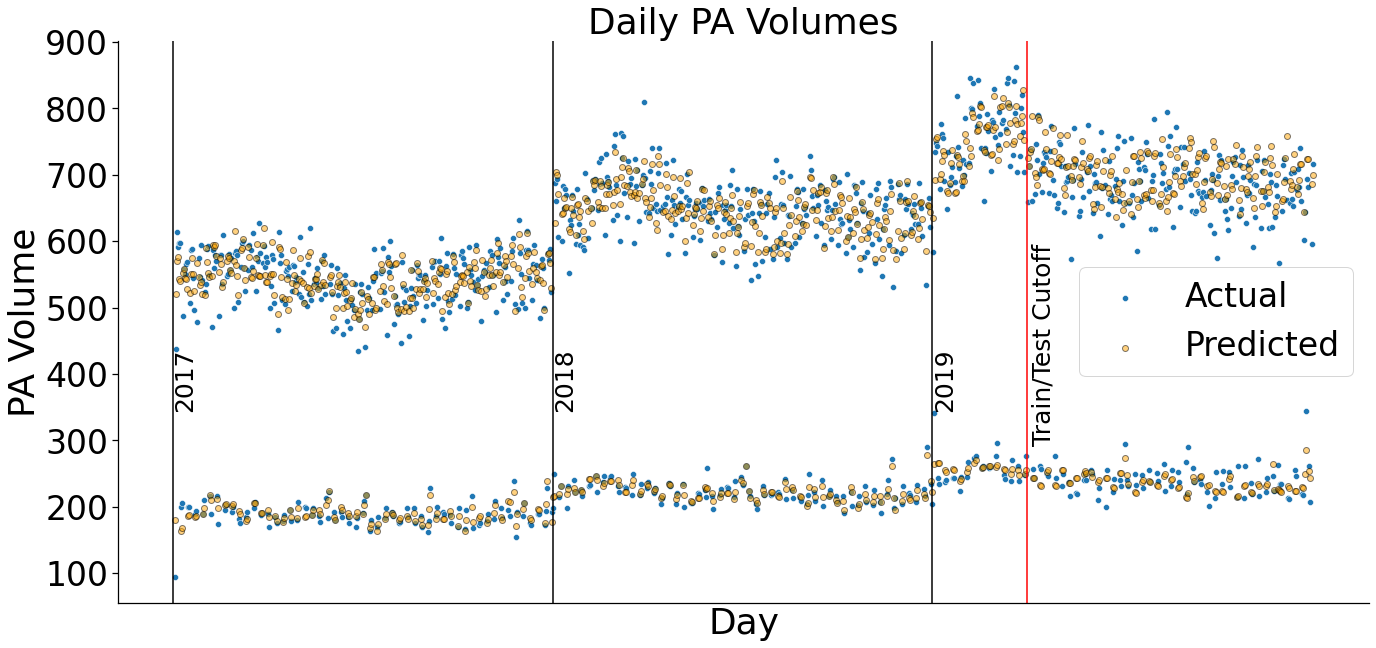

In [220]:
# Plot pa_volume_workday on the training set
# with sns.plotting_context("notebook", font_scale=3):
#     pa_volume_nonworkday_train_plot = sns.relplot(data=train_df,
#                             x='dim_date_id',
#                             y='pa_volume_nonworkday',
#                             height=10,
#                             aspect=20/10)  
#     pa_volume_nonworkday_train_plot.set(title='Interpolated Non-Workday Daily PA Volume')
#     pa_volume_nonworkday_train_plot.set_axis_labels('Date', 'PA Volume')
# plt.xticks([])
# plt.axvline(-0.5, color='black')
# plt.text(0,300,'2017',rotation=90,fontsize=25)
# plt.axvline(364.5, color='black')
# plt.text(365,300,'2018',rotation=90,fontsize=25)
# plt.axvline(729.5, color='black')
# plt.text(710,300,'2019',rotation=90,fontsize=25)
# plt.show()

# Plot daily values
with sns.plotting_context("notebook", font_scale=3):
    PA_residual_plot = sns.relplot(data=date_ext_df2,
                            x='dim_date_id',
                            y='pa_volume',
                            height=10,
                            aspect=20/10,
                            label='Actual')
    plt.scatter(date_ext_df2['dim_date_id'],
                date_ext_df2['pa_pred'],
                color='orange',
                alpha=0.5,
                edgecolors='black',
                label='Predicted')
    PA_residual_plot.set(title='Daily PA Volumes')
    PA_residual_plot.set_axis_labels('Day', 'PA Volume')
    plt.legend()
plt.xticks([])
plt.axvline(-0.5, color='black')
plt.text(0,350,'2017',rotation=90,fontsize=25)
plt.axvline(364.5, color='black')
plt.text(365,350,'2018',rotation=90,fontsize=25)
plt.axvline(729.5, color='black')
plt.text(730,350,'2019',rotation=90,fontsize=25)
plt.axvline(820.5, color='red')
plt.text(825,300,'Train/Test Cutoff',rotation=90,fontsize=25)
plt.show()

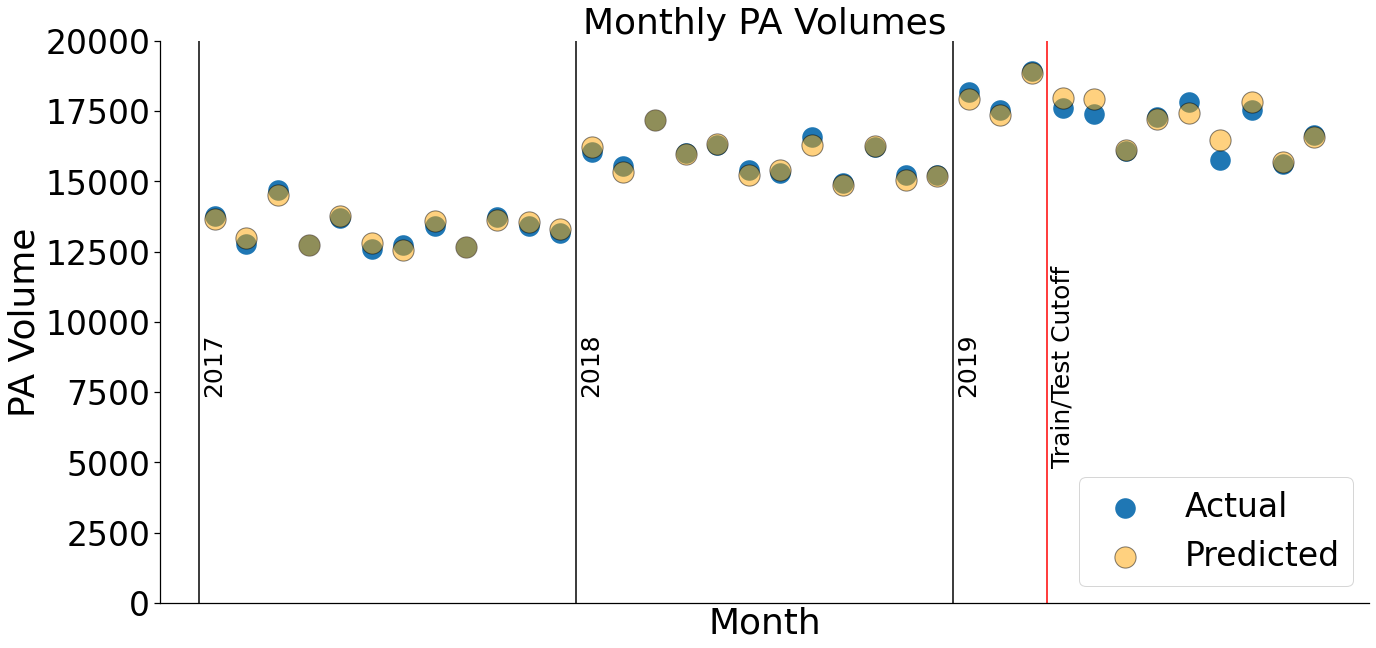

In [213]:
# Plot monthly volumes
with sns.plotting_context("notebook", font_scale=3):
    PA_residual_plot = sns.relplot(data=date_monthly_df,
                            x='month_number',
                            y='pa_volume',
                            height=10,
                            aspect=20/10,
                            s=500,
                            label='Actual')
    plt.scatter(date_monthly_df['month_number'],
                date_monthly_df['pa_pred'],
                color='orange',
                alpha=0.5,
                edgecolors='black',
                s=450,
                label='Predicted')
    PA_residual_plot.set(title='Monthly PA Volumes')
    PA_residual_plot.set_axis_labels('Month', 'PA Volume')
    plt.legend()
plt.ylim([0,20000])
plt.xticks([])
plt.axvline(0.5, color='black')
plt.text(0.6,7500,'2017',rotation=90,fontsize=25)
plt.axvline(12.5, color='black')
plt.text(12.6,7500,'2018',rotation=90,fontsize=25)
plt.axvline(24.5, color='black')
plt.text(24.6,7500,'2019',rotation=90,fontsize=25)
plt.axvline(27.5, color='red')
plt.text(27.6,5000,'Train/Test Cutoff',rotation=90,fontsize=25)
plt.show()

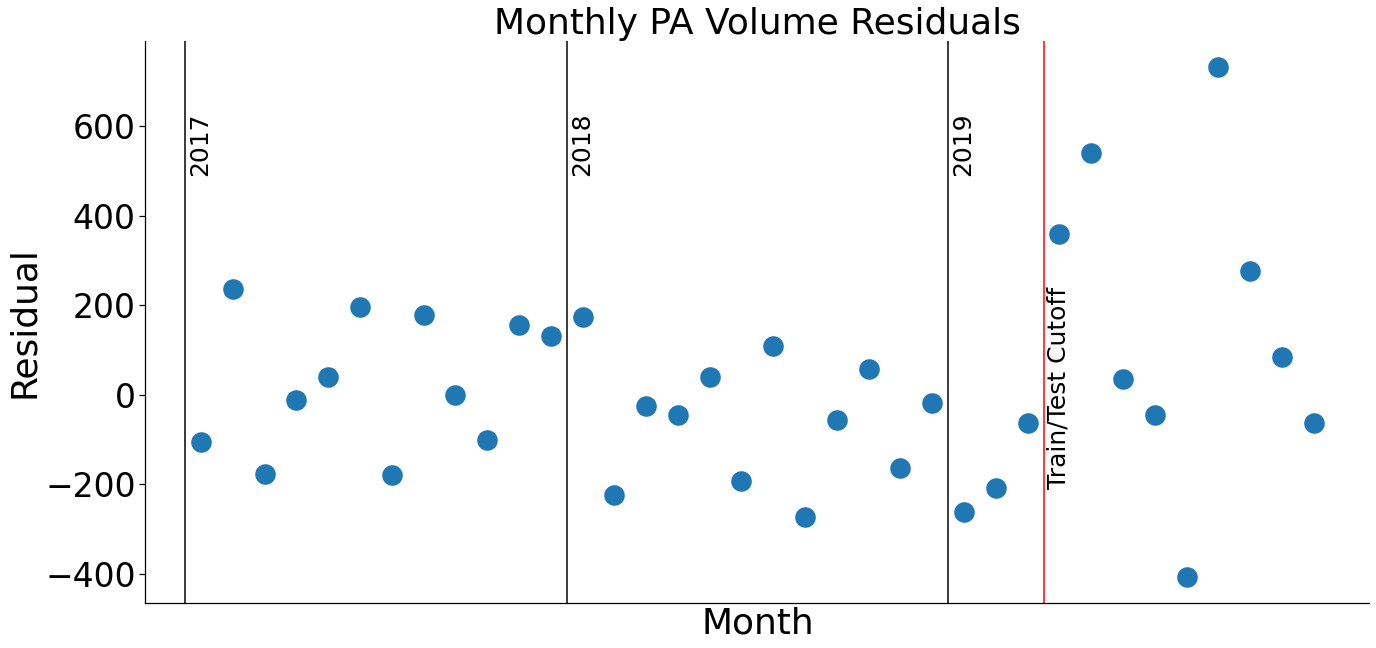

In [217]:
# Compute and plot residuals

# Add residual column to data
date_monthly_df['residuals'] = date_monthly_df['pa_pred'] - date_monthly_df['pa_volume']

# Plot residuals
with sns.plotting_context("notebook", font_scale=3):
    PA_residual_plot = sns.relplot(data=date_monthly_df,
                            x='month_number',
                            y='residuals',
                            height=10,
                            aspect=20/10,
                            s=500)
    PA_residual_plot.set(title='Monthly PA Volume Residuals')
    PA_residual_plot.set_axis_labels('Month', 'Residual')
plt.xticks([])
plt.axvline(0.5, color='black')
plt.text(0.6,500,'2017',rotation=90,fontsize=25)
plt.axvline(12.5, color='black')
plt.text(12.6,500,'2018',rotation=90,fontsize=25)
plt.axvline(24.5, color='black')
plt.text(24.6,500,'2019',rotation=90,fontsize=25)
plt.axvline(27.5, color='red')
plt.text(27.6,-200,'Train/Test Cutoff',rotation=90,fontsize=25)
plt.show()

Finally, let's show the monthly data.

In [196]:
# Show monthly data

date_monthly_df.tail(9)

,month_number,pa_volume,pa_pred,difference,error,residuals
27,28,17611.0,17970.267244,359.267244,0.020400,359.267244
28,29,17413.0,17951.966808,538.966808,0.030952,538.966808
29,30,16080.0,16114.522273,34.522273,0.002147,34.522273
30,31,17286.0,17241.297563,44.702437,0.002586,-44.702437
31,32,17837.0,17428.749403,408.250597,0.022888,-408.250597
32,33,15756.0,16489.204062,733.204062,0.046535,733.204062
33,34,17560.0,17835.207224,275.207224,0.015672,275.207224
34,35,15626.0,15709.527149,83.527149,0.005345,83.527149
35,36,16638.0,16574.378117,63.621883,0.003824,-63.621883
